In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
from pandas import DataFrame
import urllib.parse
import datetime as dt


In [2]:
def get_playercount(appid: int = 730) -> dict:
    """
    Extracts current playercount from Steam API and 24-hour and all-time peak from steamcharts.com

    Parameters:
        appid (int): Steam appid. Defaults to 730 (CS:GO)
    Returns:
        dict: A dictionary with the current playercount, 24-hour peak and all-time peak
    """
    page = requests.get(
        f'https://steamcharts.com/app/{appid}')
    soup = BeautifulSoup(page.content, 'lxml')
    tag = soup.find('div', id='app-heading')
    tags = tag.find_all('div', class_="app-stat")
    result = {}
    result['24-hour peak'] = int(tags[1].find('span').string)
    result['All-time peak'] = int(tags[2].find('span').string)
    response = requests.get(
        f'https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={appid}')
    result['Playercount'] = response.json().get(
        'response', {}).get('player_count', 0)
    return result


In [3]:
get_playercount()


{'24-hour peak': 1414684, 'All-time peak': 1519457, 'Playercount': 1167333}

In [4]:
def get_unboxing_numbers() -> DataFrame:
    """
    Extracts unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with total, monthly, weekly and daily unboxing number for every case
    """
    daily_response = requests.get(
        'https://csgocasetracker.com/calculations/calcDaily.csv')
    daily_csv = StringIO(daily_response.content.decode('utf-8'))
    weekly_response = requests.get(
        'https://csgocasetracker.com/calculations/calcWeekly.csv')
    weekly_csv = StringIO(weekly_response.content.decode('utf-8'))
    monthly_response = requests.get(
        'https://csgocasetracker.com/calculations/calculation.csv')
    monthly_csv = StringIO(monthly_response.content.decode('utf-8'))
    total_response = requests.get(
        'https://csgocasetracker.com/calculations/calculationTotal.csv')
    total_csv = StringIO(total_response.content.decode('utf-8'))
    daily_df = pd.read_csv(daily_csv, sep=',')
    weekly_df = pd.read_csv(weekly_csv, sep=',')
    monthly_df = pd.read_csv(monthly_csv, sep=',')
    total_df = pd.read_csv(total_csv, sep=',')
    result = pd.DataFrame()
    result['Case Name'] = total_df['Case Name']
    result['Total Unboxing Number'] = total_df['Unboxing Number']
    result['Monthly Unboxing Number'] = monthly_df['Unboxing Number']
    result['Weekly Unboxing Number'] = weekly_df['Unboxing Number']
    result['Daily Unboxing Number'] = daily_df['Unboxing Number']
    return result


In [5]:
get_unboxing_numbers()


,Case Name,Total Unboxing Number,Monthly Unboxing Number,Weekly Unboxing Number,Daily Unboxing Number
0,CS:GO Weapon Case,4615384,26461,6000,1538
1,eSports 2013 Case,3054153,11384,2153,153
2,Operation Bravo Case,3679866,14355,2392,0
3,CS:GO Weapon Case 2,4160256,29772,12535,3133
4,eSports 2013 Winter Case,7625830,31339,7312,3133
5,Winter Offensive Weapon Case,14013815,55822,11793,786
6,CS:GO Weapon Case 3,3997293,20370,6267,0
7,Operation Phoenix Weapon Case,54492534,415800,90720,15120
8,Huntsman Weapon Case,23727407,52649,5849,2924
9,Operation Breakout Weapon Case,59784539,362880,52920,7560


In [6]:
def get_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for an item from Steam

    Returns:
        DataFrame: A dataframe with price history containing datetimes, prices and amount sold for the given item
    """

    url = f"https://steamcommunity.com/market/listings/730/{urllib.parse.quote(item_name)}"
    response = requests.get(url).text
    response = response[response.find("line1")+6:]
    response = response[0:response.find("]];")+2]

    price_list = eval(response)
    month_list = [None,
                  'Jan',
                  'Feb',
                  'Mar',
                  'Apr',
                  'May',
                  'Jun',
                  'Jul',
                  'Aug',
                  'Sep',
                  'Oct',
                  'Nov',
                  'Dec']
    for i, entry in enumerate(price_list):
        # Date and time
        date_time = entry[0]
        date_time = date_time.split(" ")
        month = month_list.index(date_time[0])
        day = int(date_time[1])
        year = int(date_time[2])
        hour = int(date_time[3].split(":")[0])
        date_time = dt.datetime(
            year, month, day, hour=hour, minute=0, second=0)

        # Price
        price = float(entry[1])

        # Amount sold
        sold = int(entry[2])

        # compile dictionary and add it back to the list
        price_dict = {
            "Date": date_time,
            "Price(USD)": price,
            "Amount sold": sold
        }
        price_list[i] = price_dict

    df = pd.DataFrame.from_dict(price_list)

    return df


In [7]:
price_history = get_price_history('Dreams & Nightmares Case')
price_history


,Date,Price(USD),Amount sold
0,2022-01-21 01:00:00,10.675,76680
1,2022-01-22 01:00:00,6.173,70330
2,2022-01-23 01:00:00,4.914,62767
3,2022-01-24 01:00:00,4.328,52950
4,2022-01-25 01:00:00,3.996,51942
...,...,...,...
1147,2023-04-07 07:00:00,1.810,4118
1148,2023-04-07 08:00:00,1.791,3766
1149,2023-04-07 09:00:00,1.760,3656
1150,2023-04-07 10:00:00,1.730,3752


<AxesSubplot:xlabel='Date'>

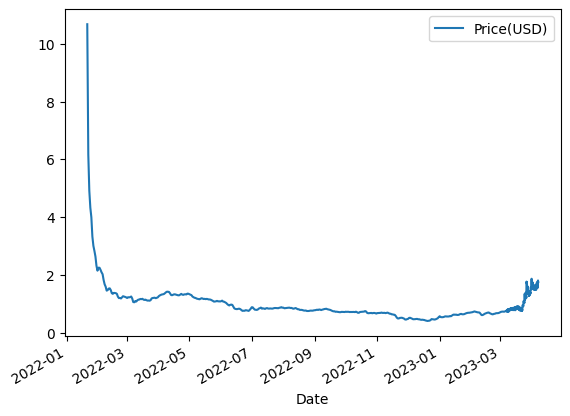

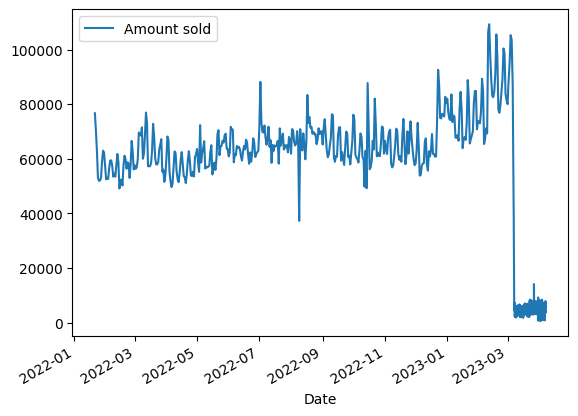

In [8]:
price_history.plot(x='Date', y='Price(USD)', rot=30)
price_history.plot(x='Date', y='Amount sold', rot=30)

In [9]:
def smoothen_price_history(df: DataFrame) -> DataFrame:
    """
    Aggregates hourly values for the past month into daily values so that time gaps between all values are consistent.

    Parameters:
        DataFrame: A dataframe with price history acquired from price_history
    Returns:
        DataFrame: A dataframe with price history with average daily prices and total daily amounts sold for the last month
    """
    df_copy = df.copy()
    df_copy['Date'] = df_copy['Date'].apply(lambda x: x.date())
    df_copy = df_copy.groupby('Date', as_index=False).agg(
        {'Price(USD)': 'mean', 'Amount sold': 'sum'})
    return df_copy


In [10]:
smooth_price_history = smoothen_price_history(price_history)
smooth_price_history


,Date,Price(USD),Amount sold
0,2022-01-21,10.675000,76680
1,2022-01-22,6.173000,70330
2,2022-01-23,4.914000,62767
3,2022-01-24,4.328000,52950
4,2022-01-25,3.996000,51942
...,...,...,...
437,2023-04-03,1.560833,115700
438,2023-04-04,1.556542,102189
439,2023-04-05,1.599167,110576
440,2023-04-06,1.659000,114218


<AxesSubplot:xlabel='Date'>

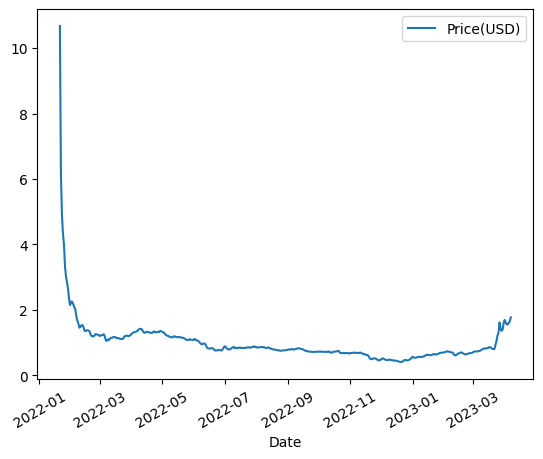

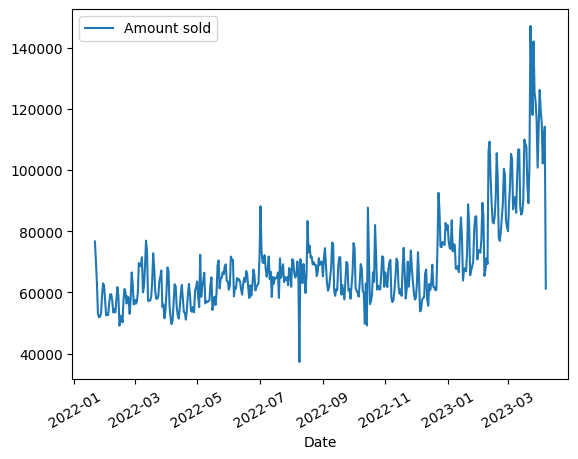

In [11]:
smooth_price_history.plot(x='Date', y='Price(USD)', rot=30)
smooth_price_history.plot(x='Date', y='Amount sold', rot=30)

In [12]:
def get_smooth_price_history(item_name: str)->DataFrame:
    """
    Extracts price history for an item from Steam with values from the last month aggregated to have daily instead of hourly data.

    Returns:
        DataFrame: A dataframe with price history containing dates, prices and amount sold for the given item
    """
    return smoothen_price_history(get_price_history(item_name))

In [13]:
smooth_price_history2 = get_smooth_price_history('Recoil Case')
smooth_price_history2

,Date,Price(USD),Amount sold
0,2022-07-01,18.725000,6647
1,2022-07-02,9.067000,65281
2,2022-07-03,6.088000,55152
3,2022-07-04,4.924000,50299
4,2022-07-05,4.465000,51490
...,...,...,...
276,2023-04-03,1.048417,104154
277,2023-04-04,1.067417,90362
278,2023-04-05,1.124500,91551
279,2023-04-06,1.135500,94516


<AxesSubplot:xlabel='Date'>

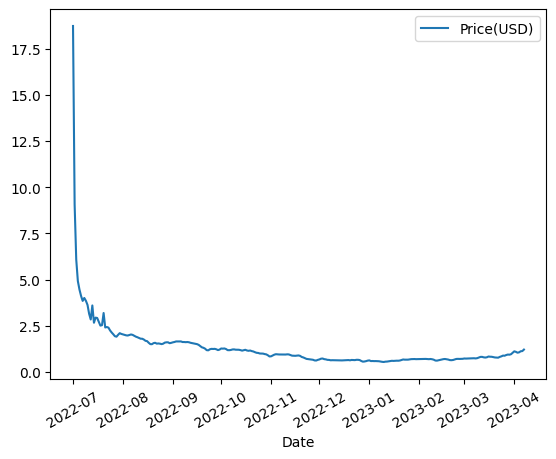

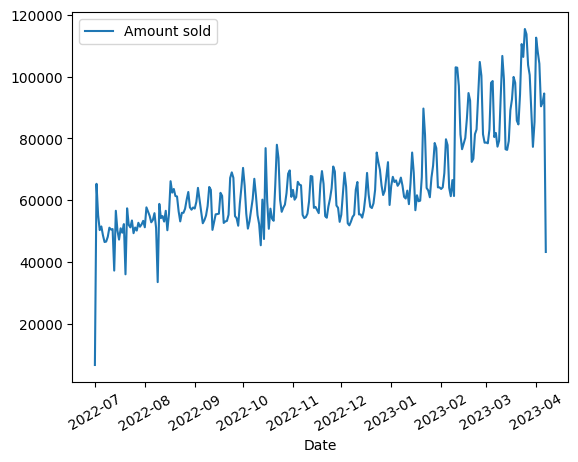

In [14]:
smooth_price_history2.plot(x='Date', y='Price(USD)', rot=30)

smooth_price_history2.plot(x='Date', y='Amount sold', rot=30)


In [ ]:
def get_historical_unboxing_numbers() -> DataFrame:
    """
    Extracts historical unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with historical monthly unboxing numbers for every case
    """
    
    # daily_response = requests.get(
    #     'https://csgocasetracker.com/calculations/calcDaily.csv')
    # daily_csv = StringIO(daily_response.content.decode('utf-8'))
    # weekly_response = requests.get(
    #     'https://csgocasetracker.com/calculations/calcWeekly.csv')
    # weekly_csv = StringIO(weekly_response.content.decode('utf-8'))
    # monthly_response = requests.get(
    #     'https://csgocasetracker.com/calculations/calculation.csv')
    # monthly_csv = StringIO(monthly_response.content.decode('utf-8'))
    # total_response = requests.get(
    #     'https://csgocasetracker.com/calculations/calculationTotal.csv')
    # total_csv = StringIO(total_response.content.decode('utf-8'))
    # daily_df = pd.read_csv(daily_csv, sep=',')
    # weekly_df = pd.read_csv(weekly_csv, sep=',')
    # monthly_df = pd.read_csv(monthly_csv, sep=',')
    # total_df = pd.read_csv(total_csv, sep=',')
    # result = pd.DataFrame()
    # result['Case Name'] = total_df['Case Name']
    # result['Total Unboxing Number'] = total_df['Unboxing Number']
    # result['Monthly Unboxing Number'] = monthly_df['Unboxing Number']
    # result['Weekly Unboxing Number'] = weekly_df['Unboxing Number']
    # result['Daily Unboxing Number'] = daily_df['Unboxing Number']
    # return result

In [16]:
csv_ids = ['january2022', 'february2022', 'march2022', 'april2022', 'may2022', 'june2022',
           'july2022', 'august2022', 'september2022', 'october2022', 'november2022',
           'december2022', 'january2023', 'february2023', 'march2023']
df_list = []
for id in csv_ids:
    response = requests.get(f'https://csgocasetracker.com/calculations/previousCalc/{id}.csv')
    csv = StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(csv,sep=',')
    df_list.append(df)
df

,Case Name,Unboxing Number,rarity,color,extraInfo
0,CS:GO Weapon Case,24461,Confirmed rare,#70AD47,1st of March 2023 – 1st of April 2023
1,eSports 2013 Case,11230,Discontinued,#ED7D31,Cases unboxed in March of 2023
2,Operation Bravo Case,14355,Confirmed rare,#70AD47,NaN
3,CS:GO Weapon Case 2,25071,Confirmed rare,#70AD47,NaN
4,eSports 2013 Winter Case,29249,Discontinued,#ED7D31,NaN
5,Winter Offensive Weapon Case,51105,Confirmed rare,#70AD47,NaN
6,CS:GO Weapon Case 3,17236,Confirmed rare,#70AD47,NaN
7,Operation Phoenix Weapon Case,400680,Confirmed rare,#70AD47,NaN
8,Huntsman Weapon Case,52649,Confirmed rare,#70AD47,NaN
9,Operation Breakout Weapon Case,415800,Confirmed rare,#70AD47,NaN


In [78]:
# Add a new column 'Month' in each dataframe to represent the month based on its position in the list
for i, df in enumerate(df_list):
    df['Month'] = i + 1  # assuming month indexing starts from 1

# Extract 'Case Name', 'Unboxing Number', and 'Month' columns from each dataframe in the list
df_list = [df[['Month', 'Case Name', 'Unboxing Number']] for df in df_list]

# Concatenate the dataframes in the list vertically
df_concatenated = pd.concat(df_list)

# Pivot the concatenated dataframe to get 'Case Name' as columns and 'Unboxing Number' as values
df_pivoted = df_concatenated.pivot(index='Case Name', columns='Month', values='Unboxing Number')

# Reset the index to make 'Case Name' a column again
df_pivoted.reset_index(inplace=True)

# Get the unique 'Case Name' values from the original dataframes in the same order
case_names_order = df_list[-1]['Case Name'].values

# Sort the dataframe based on the custom sorting order of 'Case Name'
df_pivoted = df_pivoted.sort_values(by='Case Name', key=lambda x: x.map({case: i for i, case in enumerate(case_names_order)}))

# Reset the index
df_pivoted.reset_index(drop=True, inplace=True)

# Fill in missing values with 0
df_pivoted.fillna(0, inplace=True)

# Transpose the dataframe
df_transposed = df_pivoted.set_index('Case Name').transpose()

# Remove the index name
df_transposed.index.name = None

# Add a 'Month' column with month and year values as dates
start_month = dt.date(2022, 1, 1)  # assuming start month is January 2022
df_transposed['Month'] = [start_month + pd.DateOffset(months=i) for i in range(len(df_transposed))]

# Move the 'Month' column to be the first column in the dataframe
cols = df_transposed.columns.tolist()
cols = ['Month'] + cols[:-1]
df_transposed = df_transposed[cols]

# Display the transposed dataframe
df_transposed

Case Name,Month,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
1,2022-01-01,23231.0,9846.0,19141.0,20370.0,26116.0,24373.0,6268.0,378000.0,64349.0,...,241920.0,104463.0,1525166.0,1967865.0,1259259.0,2051282.0,3063628.0,733143.0,0.0,0.0
2,2022-02-01,20923.0,6154.0,11963.0,9402.0,16714.0,22015.0,17236.0,219240.0,35100.0,...,226800.0,87369.0,1635328.0,2094649.0,1160494.0,2106363.0,2491928.0,1565052.0,0.0,0.0
3,2022-03-01,19846.0,9385.0,4785.0,12536.0,15670.0,25946.0,23504.0,309960.0,38025.0,...,340200.0,119658.0,1698006.0,2502893.0,1297246.0,2888889.0,2093067.0,2260209.0,0.0,0.0
4,2022-04-01,21077.0,6615.0,7178.0,14103.0,28205.0,28304.0,20370.0,347760.0,29250.0,...,241920.0,112061.0,1726496.0,2244841.0,1183286.0,2807217.0,1221273.0,2345679.0,0.0,0.0
5,2022-05-01,13846.0,5385.0,9571.0,10969.0,13580.0,35380.0,20370.0,272160.0,29250.0,...,173880.0,87369.0,1728395.0,2330318.0,1171890.0,2830009.0,850902.0,2184236.0,0.0,0.0
6,2022-06-01,17538.0,5231.0,11963.0,6268.0,27160.0,25946.0,25071.0,226800.0,23400.0,...,204120.0,79772.0,1530864.0,1893998.0,793922.0,2410256.0,493827.0,2351377.0,0.0,0.0
7,2022-07-01,15846.0,6154.0,7178.0,10969.0,13580.0,25159.0,14103.0,325080.0,64349.0,...,234360.0,96866.0,1726496.0,2487619.0,649573.0,2695157.0,450142.0,2763533.0,1518063.0,0.0
8,2022-08-01,17692.0,4154.0,9571.0,12536.0,9402.0,30663.0,10969.0,204120.0,29250.0,...,302400.0,72175.0,1582146.0,2692918.0,676163.0,2763533.0,402659.0,2723647.0,2044558.0,0.0
9,2022-09-01,14769.0,5538.0,9571.0,20370.0,18803.0,29091.0,14103.0,226800.0,35100.0,...,204120.0,83571.0,1460589.0,2327366.0,592593.0,2535613.0,385565.0,3012346.0,2380931.0,0.0
10,2022-10-01,15538.0,4462.0,4785.0,10969.0,12536.0,24373.0,6268.0,181440.0,29250.0,...,264600.0,70275.0,1061728.0,1991956.0,442545.0,2049383.0,260209.0,2693257.0,2082583.0,0.0


In [81]:
import pandas as pd
import datetime as dt

# Assuming df_transposed is the resulting dataframe

# Create a copy of df_transposed
df_copy = df_transposed.copy()

# Convert 'Month' column to datetime objects
df_copy['Month'] = pd.to_datetime(df_copy['Month'])

# Set 'Month' column as the index
df_copy.set_index('Month', inplace=True)

# Get the number of days in each month
df_copy['Days in Month'] = df_copy.index.daysinmonth

# Divide the monthly unboxing data by the number of days in the month to get daily unboxing data
for col in df_copy.columns[:-1]:  # exclude the last column 'Days in Month'
    df_copy[col] = df_copy[col] / df_copy['Days in Month']

# Drop the 'Days in Month' column
df_copy.drop('Days in Month', axis=1, inplace=True)

# Reset the index
df_copy.reset_index(inplace=True)

# Rename 'Month' to 'Date'
df_copy.rename(columns={'Month': 'Date'}, inplace=True)

# Display the updated dataframe
df_copy

Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-02-01,747.250000,219.785714,427.250000,335.785714,596.928571,786.250000,615.571429,7830.000000,1253.571429,...,8100.000000,3120.321429,58404.571429,74808.892857,41446.214286,75227.250000,88997.428571,55894.714286,0.000000,0.000000
2,2022-03-01,640.193548,302.741935,154.354839,404.387097,505.483871,836.967742,758.193548,9998.709677,1226.612903,...,10974.193548,3859.935484,54774.387097,80738.483871,41846.645161,93189.967742,67518.290323,72909.967742,0.000000,0.000000
3,2022-04-01,702.566667,220.500000,239.266667,470.100000,940.166667,943.466667,679.000000,11592.000000,975.000000,...,8064.000000,3735.366667,57549.866667,74828.033333,39442.866667,93573.900000,40709.100000,78189.300000,0.000000,0.000000
4,2022-05-01,446.645161,173.709677,308.741935,353.838710,438.064516,1141.290323,657.096774,8779.354839,943.548387,...,5609.032258,2818.354839,55754.677419,75171.548387,37802.903226,91290.612903,27448.451613,70459.225806,0.000000,0.000000
5,2022-06-01,584.600000,174.366667,398.766667,208.933333,905.333333,864.866667,835.700000,7560.000000,780.000000,...,6804.000000,2659.066667,51028.800000,63133.266667,26464.066667,80341.866667,16460.900000,78379.233333,0.000000,0.000000
6,2022-07-01,511.161290,198.516129,231.548387,353.838710,438.064516,811.580645,454.935484,10486.451613,2075.774194,...,7560.000000,3124.709677,55693.419355,80245.774194,20953.967742,86940.548387,14520.709677,89146.225806,48969.774194,0.000000
7,2022-08-01,570.709677,134.000000,308.741935,404.387097,303.290323,989.129032,353.838710,6584.516129,943.548387,...,9754.838710,2328.225806,51036.967742,86868.322581,21811.709677,89146.225806,12989.000000,87859.580645,65953.483871,0.000000
8,2022-09-01,492.300000,184.600000,319.033333,679.000000,626.766667,969.700000,470.100000,7560.000000,1170.000000,...,6804.000000,2785.700000,48686.300000,77578.866667,19753.100000,84520.433333,12852.166667,100411.533333,79364.366667,0.000000
9,2022-10-01,501.225806,143.935484,154.354839,353.838710,404.387097,786.225806,202.193548,5852.903226,943.548387,...,8535.483871,2266.935484,34249.290323,64256.645161,14275.645161,66109.129032,8393.838710,86879.258065,67180.096774,0.000000


In [92]:
# Assuming df_copy is the resulting dataframe

# Create a copy of df_copy
df_copy2 = df_copy.copy()

# Set 'Date' column as the index
df_copy2.set_index('Date', inplace=True)

# Get the last date in the dataframe
last_date = df_copy2.index[-1]

# Get the last row of the dataframe
last_row = df_copy2.iloc[-1]

# Set the name of the last row as the last day of the month for the last date
last_row.name = last_date + pd.offsets.MonthEnd(0)

# Concatenate the last row with the last day of the month as a new dataframe
df_copy2 = pd.concat([df_copy2, pd.DataFrame([last_row], columns=df_copy2.columns)])

# Resample the dataframe to daily frequency and forward fill the values
df_copy2 = df_copy2.resample('D').ffill()

# Reset the index
df_copy2.reset_index(inplace=True)

# Display the updated dataframe
df_copy2

Case Name,index,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2023-03-27,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129
451,2023-03-28,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129
452,2023-03-29,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129
453,2023-03-30,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129
